# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

Two-level ensemble

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init, doubleJetCase_meargs = doubleJetCase.getInitConditions()

In [7]:
coarse_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
coarse_doubleJetCase_args, coarse_doubleJetCase_init, _ = coarse_doubleJetCase.getInitConditions()

In [8]:
doubleJetCase_meargs = {
                            "basis_x_start": 2, 
                            "basis_x_end": 8,
                            "basis_y_start": 1,
                            "basis_y_end": 7,

                            "kl_decay": 1.25,
                            "kl_scaling": 0.025,
                            }

sim_model_error_time_step = 60.0                        

In [9]:
ML_Nes = [100, 50]
doubleJetCase_args_list = [coarse_doubleJetCase_args, doubleJetCase_args]
doubleJetCase_init_list = [coarse_doubleJetCase_init, doubleJetCase_init]

In [10]:
mekls = []
for l_idx in range(len(doubleJetCase_args_list)): 
    grid_args = {key: doubleJetCase_args_list[l_idx][key] for key in ('nx', 'ny', 'dx', 'dy', 'gpu_ctx', 'boundary_conditions')}
    mekls.append( ModelErrorKL.ModelErrorKL(gpu_stream=gpu_stream, **grid_args, **doubleJetCase_meargs) )

In [11]:
from utils.DoubleJetEnsembleInit import *
ML_ensemble = initMLensemble(ML_Nes, doubleJetCase_args_list, doubleJetCase_init_list,
                             sim_model_error_basis_args=doubleJetCase_meargs,
                             sim_model_error_time_step=60.0)

0
1


In [12]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

## Drifter

In [13]:
xdim = MLOceanEnsemble.dxs[-1]*MLOceanEnsemble.nxs[-1]
ydim = MLOceanEnsemble.dys[-1]*MLOceanEnsemble.nys[-1]

In [ ]:
num_drifters = 100

In [14]:
init_positions = np.c_[np.random.uniform(high=xdim, size=num_drifters), np.random.uniform(high=ydim, size=num_drifters)]

In [15]:
# Open output in VSC texteditor and copy!
init_positions

array([[ 623494.67689421,  461948.71095606],
       [ 471598.13025989,  142813.37348377],
       [ 105458.32679044,  368550.10580986],
       [1318878.73163322,  280606.49126477],
       [  94095.97141788,  518483.45507089],
       [ 949557.48287376,  215007.46835206],
       [ 151591.65312723,  171545.54341663],
       [  44960.20421744,  339574.34194872],
       [1221038.21553879,  487865.13267382],
       [ 498040.10824289,  662212.38658787],
       [ 429406.43527084,  288155.61847832],
       [ 346493.44521206,  158329.50765771],
       [ 572539.49151851,  477002.30464412],
       [ 872946.5781627 ,  261138.49727745],
       [1249125.87783518,  423069.12806816],
       [ 850515.35785149,  158103.19931716],
       [ 112699.30603473,  280813.84781278],
       [ 264056.93611736,  663394.12328192],
       [1222302.59363903,  104979.95588593],
       [ 397525.86355936,  545752.69617229],
       [1021319.11280169,  238508.21692852],
       [ 910578.45272444,  506676.88565857],
       [10

In [16]:
extent=[0, MLOceanEnsemble.dxs[-1]*MLOceanEnsemble.nxs[-1], 0, MLOceanEnsemble.dys[-1]*MLOceanEnsemble.nys[-1]]

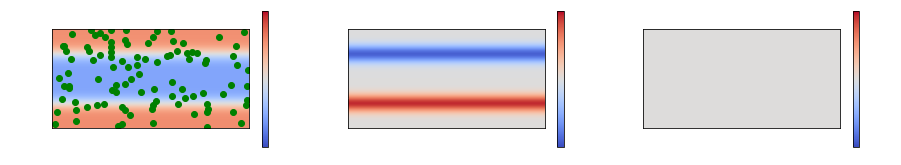

In [17]:
from utils.DoubleJetPlot import *
fig, axs = imshow3(MLOceanEnsemble.estimate(np.mean), extent=extent)
axs[0].scatter(init_positions[:,0], init_positions[:,1], c="green")

In [18]:
MLOceanEnsemble.stepToObservation(900)